In this notebook, we experiment with the Bias-Aware Clustering algorithm to identify Which of the clustering algorithms (K-Means, DBSCAN or MeanShift) perform best in identifying biased clusters. The experiment is conducted the German Credit Risk dataset, of which the dimensions are reduced with PCA. 


### Init


In [20]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [7]:
# raw_data = pd.read_csv(r'..\Preprocessed_datasets\pca_german_credit.csv', index_col=0)
raw_data = pd.read_csv(r'..\Preprocessed_datasets\pca_german_credit.csv', index_col=0)
# raw_data['scaled_errors'] = raw_data['errors']
errors = raw_data['errors']
features = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)
raw_data.head()

x         y  label  clusters  new_clusters  true_class  \
0 -7.139746 -0.306166      0         0            -1         1.0   
1 -3.003995  4.753761      3         0            -1         0.0   
2 -1.083714 -9.061701      1         0            -1         1.0   
3 -2.355728 -8.342408      2         0            -1         0.0   
4 -5.842445  5.701036      3         0            -1         0.0   

   predicted_class  errors  scaled_errors  
0              0.0     1.0            1.0  
1              1.0     1.0            1.0  
2              1.0     0.0            0.0  
3              1.0     1.0            1.0  
4              1.0     1.0            1.0

### Scaling the features

In [3]:
# # Scaling all attributes
# to_scale = features.columns
# features[to_scale] = StandardScaler().fit_transform(features[to_scale])
# features[:5]

# # Scaling the errors
# errors_col = MinMaxScaler(feature_range = (0,1.0)).fit_transform(raw_data[['errors']])
# scaling_factor = 0.3 #needs to be converted to scaling range
# scaled_errors = scaling_factor * errors_col

### Utils

In [11]:
def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    """Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """
    new_data = raw_data.copy(deep=True)
    
    if with_errors:
        errors_col = MinMaxScaler(feature_range = (0, 1.0)).fit_transform(new_data[['errors']])
        scaling_factor = 1.0 #needs to be converted to scaling range [0.2 - 1.2]
        scaled_errors = scaling_factor * errors_col
        new_data['scaled_errors'] = scaled_errors

    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_random_cluster(clusters):
    """This function returns the value of a random cluster
    clusters Df.Column the column clusters"""
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    return result

def plot_clusters(data):
    """This function returns a scatterplot of the clusters"""    
    scatterplot = sns.scatterplot(data=data, x='x', y='y', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    """This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" """ 
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    """ This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are """
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. cluster ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    """ This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are """
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    """ This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors" """
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    """ This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters """
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    """ This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters"""
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_abs_bias_cluster(fulldata, function=bias_acc):
    """ This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters """
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = function(fulldata, cluster_number, "clusters") # abs function
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    return best_cluster

def calculate_variance(data):
    """This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg"""
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    """Returns the size of the smallest new cluster"""
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

## Dimensionality Reduction with PCA

In [10]:
# working code
# dataset = initialize_dataset(raw_data)
# pca_features = dataset.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
# other_features = dataset[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]

# df = pd.DataFrame(pca_features)
# pca_model = PCA(n_components=2)
# pca = pd.DataFrame(pca_model.fit_transform(df), index=df.index)

# full_dataset = pca.join(other_features, how='left')
# full_dataset.rename( columns={0 :'1st'}, inplace=True )
# full_dataset.rename( columns={1 :'2nd'}, inplace=True )
# full_dataset

169


## 1. Bias-Aware KMeans Clustering 

In [12]:
full_data = raw_data.copy(deep=True)
full_data.head()
full_data['scaled_errors'] = full_data['scaled_errors'].replace(0.3, 1.0)
full_data.head()

x         y  label  clusters  new_clusters  true_class  \
0 -7.139746 -0.306166      0         0            -1         1.0   
1 -3.003995  4.753761      3         0            -1         0.0   
2 -1.083714 -9.061701      1         0            -1         1.0   
3 -2.355728 -8.342408      2         0            -1         0.0   
4 -5.842445  5.701036      3         0            -1         0.0   

   predicted_class  errors  scaled_errors  
0              0.0     1.0            1.0  
1              1.0     1.0            1.0  
2              1.0     0.0            0.0  
3              1.0     1.0            1.0  
4              1.0     1.0            1.0

In [10]:
# TODO: experiment with different random states, increase number of runs
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2,
}

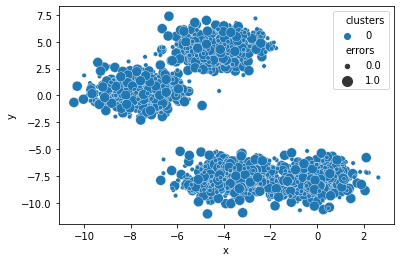

average_accuracy is:  0.536


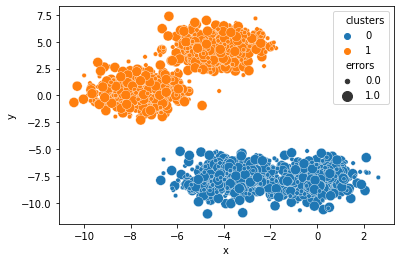

--> Cluster with the highest variance: 1


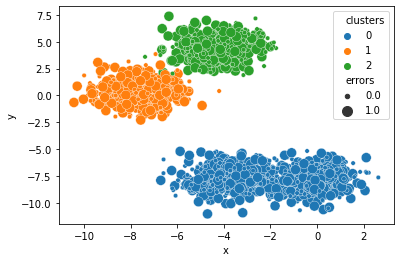

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 2


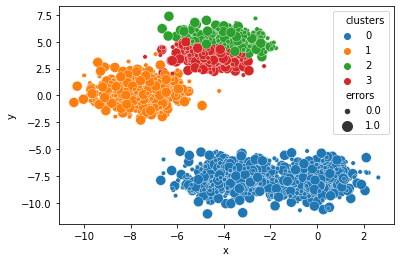

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 3


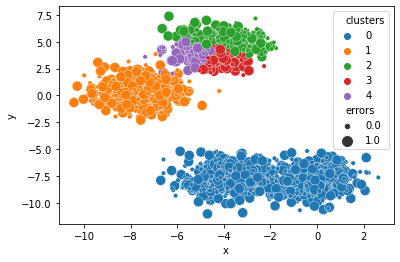

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 2


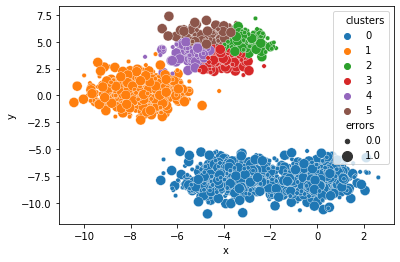

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 5


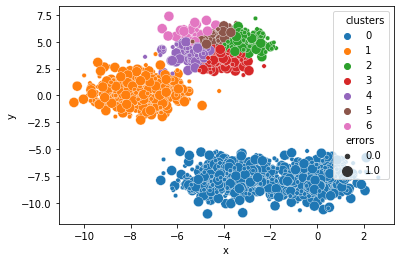

--> Cluster with the highest variance: 1


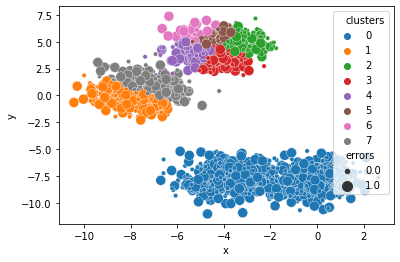

--> Cluster with the highest variance: 1


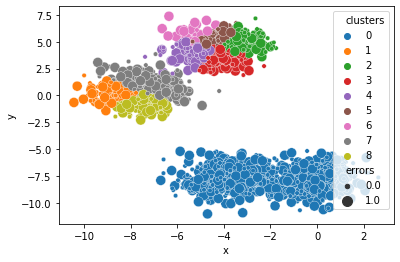

--> Cluster with the highest variance: 8


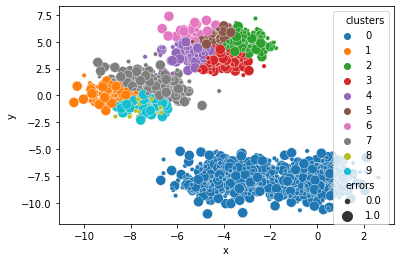

--> Cluster with the highest variance: 9
--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 7


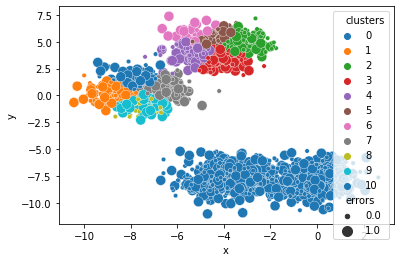

--> Cluster with the highest variance: 9
--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 10


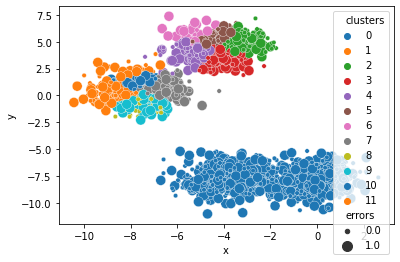

--> Cluster with the highest variance: 9
--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 0


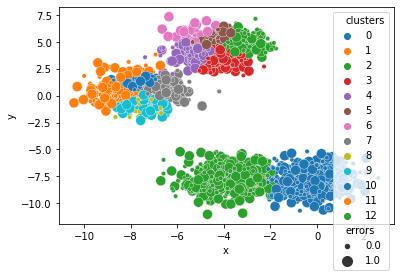

--> Cluster with the highest variance: 9
--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 0


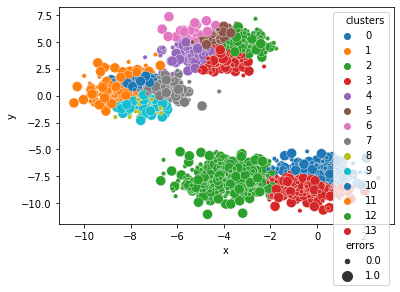

--> Cluster with the highest variance: 9
--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 13


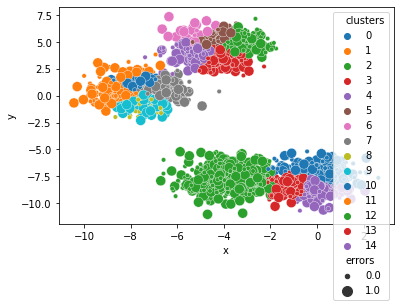

--> Cluster with the highest variance: 9
--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 13
--> Cluster with the highest variance: 14


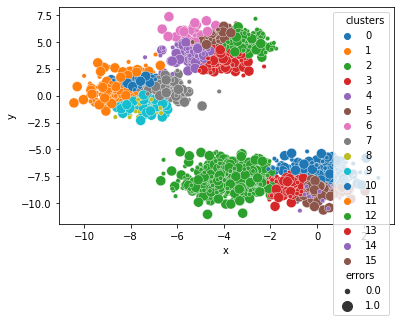

--> Cluster with the highest variance: 9
--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 13


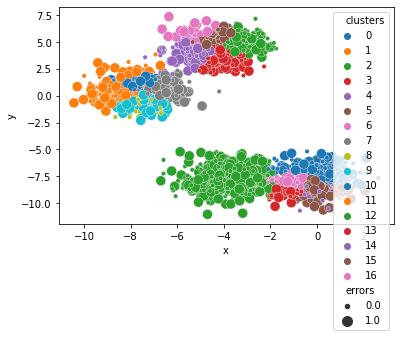

--> Cluster with the highest variance: 9
--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 13


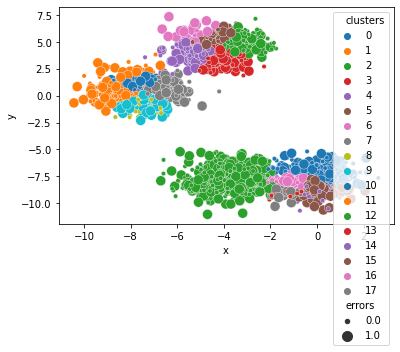

--> Cluster with the highest variance: 9
--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 10


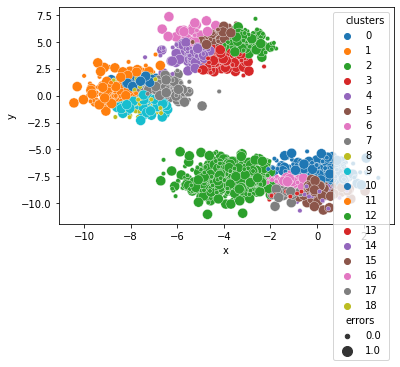

--> Cluster with the highest variance: 9
--> Cluster with the highest variance: 2


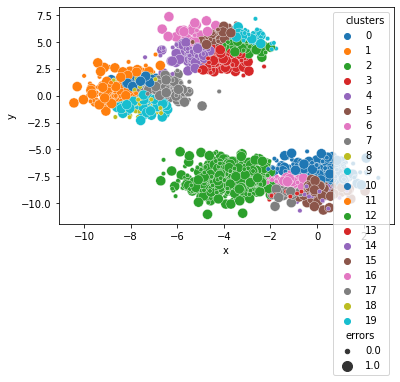

--> Cluster with the highest variance: 9
--> Cluster with the highest variance: 2
--> Cluster with the highest variance: 12
--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 4
MAX_ITER
[0.001024000000000002, 0.0014332839506172874, 0.001785138865392196, 0.004219239458534274, 0.004132460845038947, 0.024638560787647115, 0.02217330382148237, 0.020345167974230173, 0.07127289646695276, 0.06513744119769646, 0.0606190423614738, 0.05627349152447925, 0.0525879596620018, 0.04932417494110725, 0.08003678315788529, 0.07588537629928699, 0.10002153974599552, 0.12196141019614243]


In [13]:
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list = []
average_accuracy = accuracy(full_data) 
minimal_splittable_cluster_size = 5
minimal_acceptable_cluster_size = 8
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply Kmeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class',                                                                                                               'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_negative_bias(full_data) # was get_max_abs_bias
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #abs: >
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')



print(variance_list)


### 1. Analysing the clustering results


In [14]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
# print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"cluster {c} has the highest negative bias")
print(most_biased_cluster_kmeans_aware)

9 has bias -0.551440329218107
2 has bias -0.2441738961386115
13 has bias 0.4691607684529828
12 has bias 0.045095840775501994
6 has bias -0.4159919028340081
0 has bias 0.03657951833082107
8 has bias 0.4778578784757982
15 has bias -0.5589155370177268
4 has bias -0.10434322033898302
3 has bias 0.06211565335406011
19 has bias 0.1476923076923078
5 has bias 0.056140350877192935
17 has bias -0.5430597771023303
7 has bias 0.034090245753312653
1 has bias 0.04256699759911753
14 has bias 0.4818276220145379
11 has bias -0.13035234930825407
16 has bias 0.06480721903199338
18 has bias 0.47443762781186094
10 has bias -0.5455470737913486
General accuracy of classifier on this dataset: 0.536
cluster 15 has the highest negative bias
-0.5589155370177268


Text(0.5, 1.0, 'Negative Bias Variance of Instances')

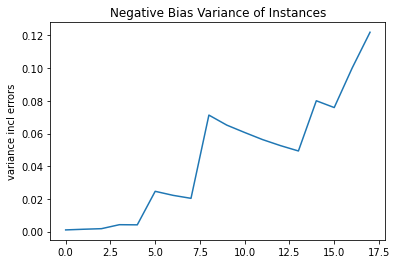

In [15]:
variance_df_kmeans = pd.DataFrame(variance_list).rename(columns={0:"variance incl errors"})
sns.lineplot(data=variance_df_kmeans, x=variance_df_kmeans.index,y="variance incl errors").set_title('Negative Bias Variance of Instances')

In [19]:
# bias_cluster = full_data[full_data['clusters']==15]
# bias_cluster['scaled_errors'] ==
# # bias_cluster['errors']==1.0

x         y  label  clusters  new_clusters  true_class  \
13    0.736682 -8.810410      1        15          -1.0         0.0   
77   -0.024788 -8.417701      1        15          -1.0         1.0   
84   -0.100554 -8.941130      1        15          -1.0         0.0   
103   0.128312 -8.226638      1        15          -1.0         0.0   
128   0.597249 -8.225110      1        15          -1.0         1.0   
...        ...       ...    ...       ...           ...         ...   
1937 -0.237861 -7.790128      1        15          -1.0         0.0   
1948 -0.372497 -8.380423      1        15          -1.0         0.0   
1954 -0.310071 -8.472973      1        15          -1.0         0.0   
1981 -0.089100 -7.906175      1        15          -1.0         1.0   
1990 -0.115037 -8.764061      1        15          -1.0         1.0   

      predicted_class  errors  scaled_errors  
13                1.0     1.0            1.0  
77                0.0     1.0            1.0  
84                1.0     1.0            1.0  
103               1.0     1.0            1.0  
128               0.0     1.0            1.0  
...               ...     ...            ...  
1937              1.0     1.0            1.0  
1948              1.0     1.0            1.0  
1954              1.0     1.0            1.0  
1981              0.0     1.0            1.0  
1990              0.0     1.0            1.0  

[82 rows x 9 columns]

## Baseline KMeans

In [11]:
# to add: calculation for the silhouette score and elbow method to base the number of clusters on? 
# Or should I just use the found number of clusters by the bias-aware clustering algorithm?


In [44]:
full_data = raw_data.copy(deep=True)
full_data.head()

1st       2nd  scaled_errors  predicted_class  true_class  errors  \
136 -1.468126  0.624496            0.0                0         0.0     0.0   
76  -1.417878 -0.950103            0.3                0         1.0     1.0   
280 -0.078468  2.895461            0.0                0         0.0     0.0   
319 -1.625901  0.254482            0.0                0         0.0     0.0   
174 -1.660360 -0.534133            0.3                0         1.0     1.0   

     clusters  new_clusters  
136         0            -1  
76          0            -1  
280         0            -1  
319         0            -1  
174         0            -1

In [45]:
# Same number of clusters as the found clusters by the bias-aware clustering algorithm?
baseline_kmeans = KMeans(n_clusters=2, init="k-means++", n_init=10, max_iter=300, random_state=2).fit(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    

full_data['clusters'] = pd.DataFrame(baseline_kmeans.predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class',                                                                                                               'errors'], axis=1)),index=full_data.index) 


In [46]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_baselinekm = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_baselinekm)

1 has bias -0.04887328065554586
0 has bias 0.04887328065554586
cluster 1 has the highest negative bias
[1 0]
Overall accuracy: 0.6272189349112426
Highest found negative bias: -0.04887328065554586


## 2. Bias-Aware DBSCAN

In [85]:
from sklearn.cluster import DBSCAN

In [32]:
full_data = raw_data.copy(deep=True)
full_data.head()

1st       2nd  scaled_errors  predicted_class  true_class  errors  \
136 -1.468126  0.624496            0.0                0         0.0     0.0   
76  -1.417878 -0.950103            0.3                0         1.0     1.0   
280 -0.078468  2.895461            0.0                0         0.0     0.0   
319 -1.625901  0.254482            0.0                0         0.0     0.0   
174 -1.660360 -0.534133            0.3                0         1.0     1.0   

     clusters  new_clusters  
136         0            -1  
76          0            -1  
280         0            -1  
319         0            -1  
174         0            -1

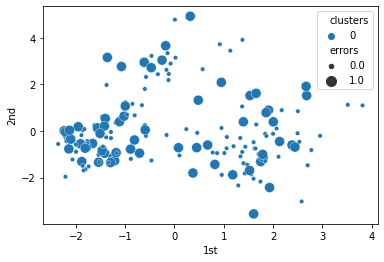

this is the current cluster:  0
This cluster is the entire dataset. cluster  0
You are calculating the accuracy on a empty cluster


ZeroDivisionError: division by zero

In [31]:
MAX_ITER = 20 #should be increased, but then I should increase all the max iterations for all bias-aware algorithms
epsilon = 2
minimum_samples = 2
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list = []
minimal_splittable_cluster_size = 3
minimal_acceptable_cluster_size = 1
average_accuracy = accuracy(full_data)

for i in range(1, MAX_ITER):
    print('this is the current cluster: ', x)
    epsilon = epsilon - 0.2
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -2
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply DBSCAN
    candidate_cluster['new_clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #>
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        # print(full_data['new_clusters'])
        
        first = True
        dif = 1
        for clstr in full_data['new_clusters'].unique():
            if (clstr == -1):
                full_data['clusters'][full_data['new_clusters'] == clstr] = -1
            elif (clstr == -2):
                continue
            elif first:
                full_data['clusters'][full_data['new_clusters'] == clstr] = x
                first = False
            else:
                full_data['clusters'][full_data['new_clusters'] == clstr] =  n_cluster + dif
                dif += 1

        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

## 2. DBSCAN Results

In [16]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_dbscan_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_dbscan_aware)

0 has bias -0.05004389815627752
3 has bias -0.4402439024390244
8 has bias 0.38414634146341464
9 has bias -0.05820105820105825
1 has bias 0.04016064257028107
4 has bias 0.38414634146341464
5 has bias 0.37951807228915657
2 has bias 0.12575757575757573
10 has bias -0.2991967871485944
11 has bias -0.38636363636363635
6 has bias 0.38181818181818183
7 has bias 0.37951807228915657
cluster 3 has the highest negative bias
[-1  0  3  8  9  1  4  5  2 10 11  6  7]
Overall accuracy: 0.6272189349112426
Highest found negative bias: -0.4402439024390244


<AxesSubplot:ylabel='variance excl errors'>

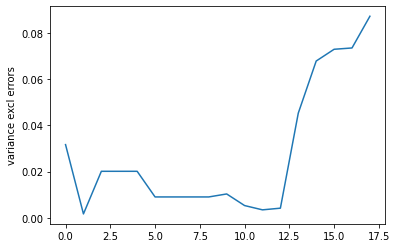

In [17]:
variance_df_dbscan = pd.DataFrame(variance_list).rename(columns={0:"variance excl errors"})
sns.lineplot(data=variance_df_dbscan, x=variance_df_dbscan.index,y="variance excl errors")

## DBSCAN Baseline

In [18]:
full_data = initialize_dataset(raw_data)

[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1  1]
[ 0 -1  1]
[ 0 -1  1]
[ 0 -1  1]
[ 0 -1  1]
[ 0 -1  1]
[ 0 -1  1  2]
[ 0 -1  1  2]
[ 0 -1  1  2]
[ 0 -1  1  2]
[-1  0  1  2  3  4]
[-1  0  1  2  3  4]
[-1  0  1  2  3  4]
[-1  0  1  2  3  4]
[-1  0  1  2  3  4]
[-1  0  1  2  3  4]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  8  9  

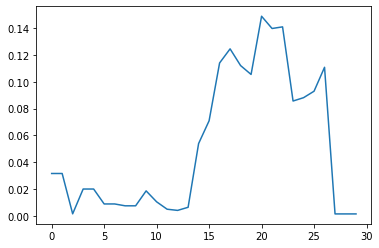

In [19]:
var_list = []
epsilon = 7
minimum_samples = 3
features_i = features.copy(deep=True)
features_i["errors"] = errors

for n in range(2, 58):
    model = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(features_i)
    features_i['cluster_results'] = pd.DataFrame(model, index=features_i.index)

    neg_bias_list = []
    epsilon = epsilon-0.2
    if  len(features_i["cluster_results"].unique()) == 1:
        print("One cluster left on iteration ", n)
        print("With epsilon", epsilon)
        break
    for i in features_i["cluster_results"].unique():
        print(features_i["cluster_results"].unique())
        #print('features_i', features_i)
        neg_bias_list.append(bias_acc(features_i, i,"cluster_results"))
    var_list.append(np.var(neg_bias_list))
# print(var_list)

plt.plot(var_list)

## 3. Bias-Aware Mean Shift 


The estimate_bandwidth function to estimate the bandwidth parameter of Mean Shift is significantly better than manually selecting a bandwidth value.

In [36]:
from sklearn.cluster import MeanShift, estimate_bandwidth 
# full_data = initialize_dataset(raw_data)
full_data = raw_data.copy(deep=True)
full_data.head()

1st       2nd  scaled_errors  predicted_class  true_class  errors  \
136 -1.468126  0.624496            0.0                0         0.0     0.0   
76  -1.417878 -0.950103            0.3                0         1.0     1.0   
280 -0.078468  2.895461            0.0                0         0.0     0.0   
319 -1.625901  0.254482            0.0                0         0.0     0.0   
174 -1.660360 -0.534133            0.3                0         1.0     1.0   

     clusters  new_clusters  
136         0            -1  
76          0            -1  
280         0            -1  
319         0            -1  
174         0            -1

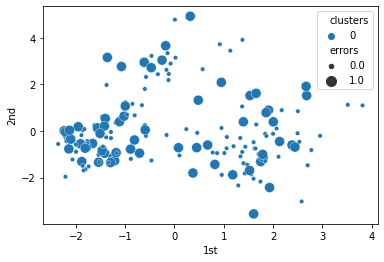

average_accuracy is:  0.6272189349112426
smallest cluster: 75
CHECK!


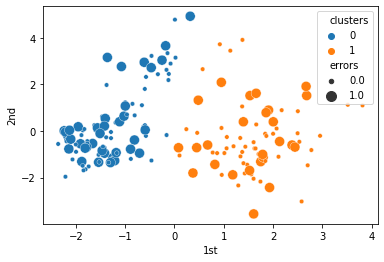

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


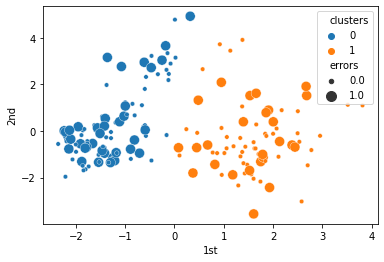

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


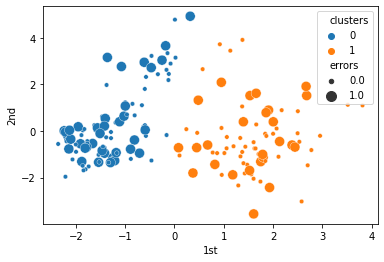

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


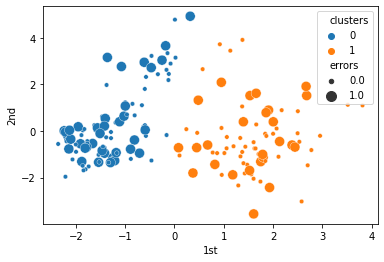

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


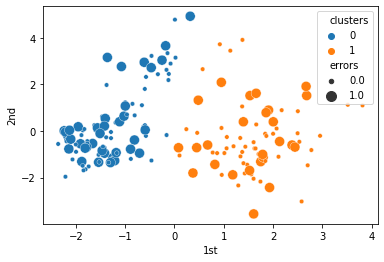

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


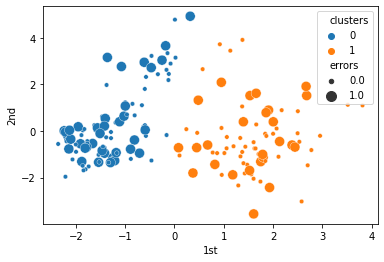

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


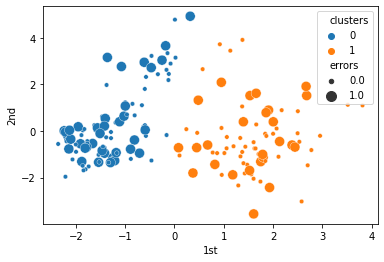

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


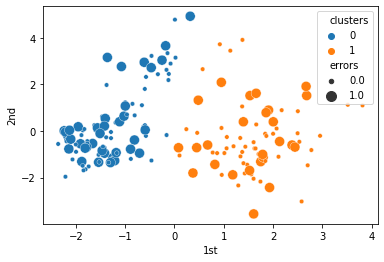

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


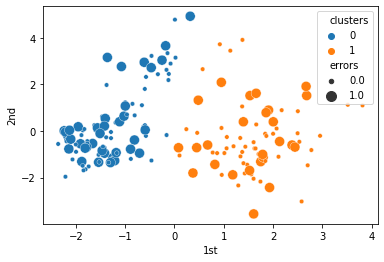

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


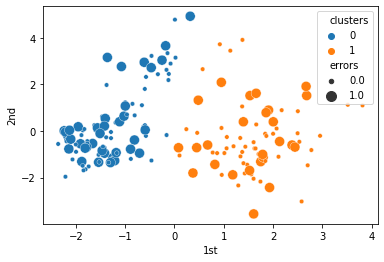

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


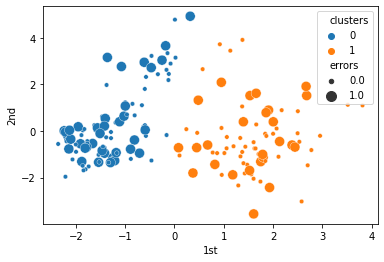

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


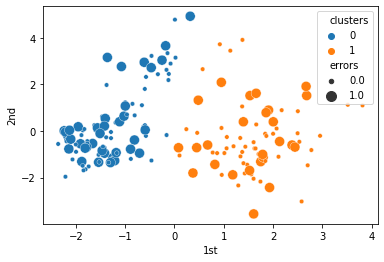

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


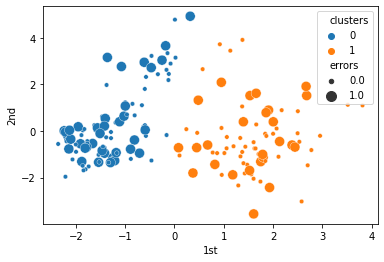

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


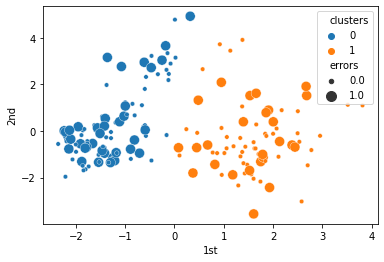

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


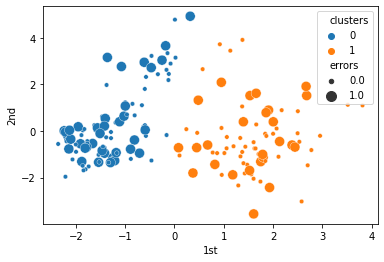

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


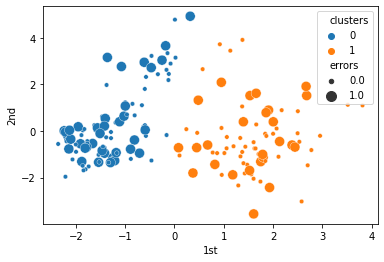

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


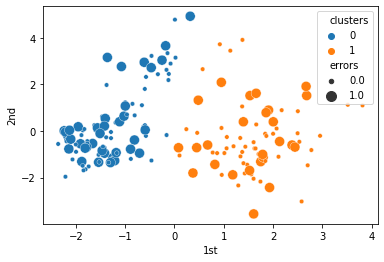

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


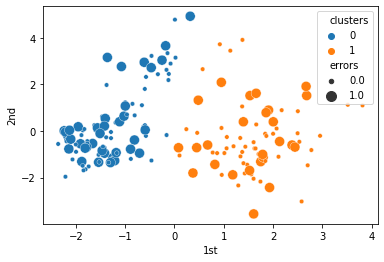

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


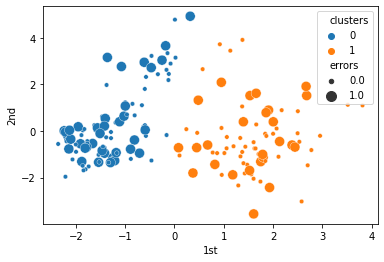

--> Cluster with the highest variance: 0
MAX_ITER
[0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568]


In [37]:
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
# bw1 = 1.5
bw1 = estimate_bandwidth(full_data)
plot_clusters(full_data)
variance_list = []
average_accuracy = accuracy(full_data) 
minimal_splittable_cluster_size = 5
minimal_acceptable_cluster_size = 0
print("average_accuracy is: ", average_accuracy) 


for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply MeanShift
    candidate_cluster['new_clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class',                                                    'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters']) 

    max_abs_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster:",min_new_size)
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): 
        print("CHECK!")
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

## 3. Mean-Shift Results

In [38]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_meanshift_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_meanshift_aware)

0 has bias -0.07092198581560283
1 has bias 0.07092198581560283
cluster 0 has the highest negative bias
[0 1]
Overall accuracy: 0.6272189349112426
Highest found negative bias: -0.07092198581560283


<AxesSubplot:ylabel='variance incl errors'>

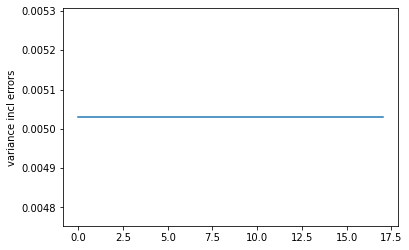

In [39]:
variance_df = pd.DataFrame(variance_list).rename(columns={0:"variance incl errors"})
sns.lineplot(data=variance_df, x=variance_df.index,y="variance incl errors")

## Baseline Mean Shift

In [40]:
# full_data = initialize_dataset(raw_data)

full_data = raw_data.copy(deep=True)
full_data.head()

1st       2nd  scaled_errors  predicted_class  true_class  errors  \
136 -1.468126  0.624496            0.0                0         0.0     0.0   
76  -1.417878 -0.950103            0.3                0         1.0     1.0   
280 -0.078468  2.895461            0.0                0         0.0     0.0   
319 -1.625901  0.254482            0.0                0         0.0     0.0   
174 -1.660360 -0.534133            0.3                0         1.0     1.0   

     clusters  new_clusters  
136         0            -1  
76          0            -1  
280         0            -1  
319         0            -1  
174         0            -1

In [41]:
bw1 = estimate_bandwidth(full_data)

full_data['clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class',                                                    'true_class', 'errors'], axis=1)), index=full_data.index)

In [42]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_baselinemeanshift = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_baselinemeanshift)

0 has bias -0.07092198581560283
1 has bias 0.07092198581560283
cluster 0 has the highest negative bias
[0 1]
Overall accuracy: 0.6272189349112426
Highest found negative bias: -0.07092198581560283


## Goal 1: Comparing Bias-Aware KMeans/DBSCAN/MeanShift with finding the highest negatively biased cluster

<BarContainer object of 5 artists>

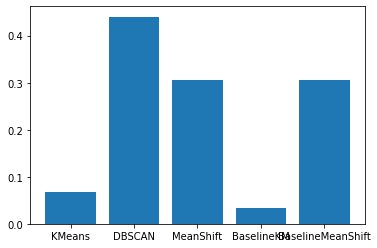

In [33]:
results_array = []

# the minus is to make the values positive, as that makes it easier to find the highest negative biased cluster
results_array.append(-most_biased_cluster_kmeans_aware)
results_array.append(-most_biased_cluster_dbscan_aware)
results_array.append(-most_biased_cluster_meanshift_aware)
results_array.append(-most_biased_cluster_baselinekm)
results_array.append(-most_biased_cluster_baselinemeanshift)


plt.bar(['KMeans', 'DBSCAN', 'MeanShift', 'BaselineKM', 'BaselineMeanShift'], results_array)
# todo: add baselines


In [47]:
full_data = raw_data.copy(deep=True)
full_data.head()

# full_data = initialize_dataset(raw_data)

1st       2nd  scaled_errors  predicted_class  true_class  errors  \
136 -1.468126  0.624496            0.0                0         0.0     0.0   
76  -1.417878 -0.950103            0.3                0         1.0     1.0   
280 -0.078468  2.895461            0.0                0         0.0     0.0   
319 -1.625901  0.254482            0.0                0         0.0     0.0   
174 -1.660360 -0.534133            0.3                0         1.0     1.0   

     clusters  new_clusters  
136         0            -1  
76          0            -1  
280         0            -1  
319         0            -1  
174         0            -1

One cluster left on iteration  2
With epsilon 6.8
[]


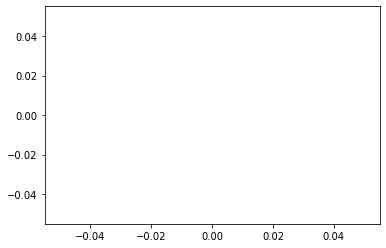

In [48]:
var_list = []
epsilon = 7
minimum_samples = 3
features_i = features.copy(deep=True)
features_i["errors"] = errors

for n in range(2, 58):
    model = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(features_i)
    features_i['cluster_results'] = pd.DataFrame(model, index=features_i.index)

    neg_bias_list = []
    epsilon = epsilon-0.2
    if  len(features_i["cluster_results"].unique()) == 1:
        print("One cluster left on iteration ", n)
        print("With epsilon", epsilon)
        break
    for i in features_i["cluster_results"].unique():
        print(features_i["cluster_results"].unique())
        #print('features_i', features_i)
        neg_bias_list.append(bias_acc(features_i, i,"cluster_results"))
    var_list.append(np.var(neg_bias_list))
print(var_list)

plt.plot(var_list)

## MeanShift without recursivity

In [36]:
full_data = initialize_dataset(raw_data)

In [37]:
bw1 = estimate_bandwidth(full_data)

full_data['clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class',                                                    'true_class', 'errors'], axis=1)), index=full_data.index)

In [38]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_baselinemeanshift = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_baselinemeanshift)

0 has bias 0.08745684695051792
1 has bias -0.3047034764826176
3 has bias 0.375
4 has bias 0.375
2 has bias -0.12874251497005984
5 has bias 0.375
cluster 1 has the highest negative bias
[0 1 3 4 2 5]
Overall accuracy: 0.6272189349112426
Highest found negative bias: -0.3047034764826176


In [ ]:
var_list = []

# experimenting with the bandwidth parameter
bw1 = estimate_bandwidth(features_i)
bw2 = None
features_i = features.copy(deep=True)
features_i["errors"] = errors

for n in range(2, 58):
    model = MeanShift(bandwidth=bw1).fit_predict(features_i)
    features_i['cluster_results'] = pd.DataFrame(model, index=features_i.index)
    #features['cluster_results'] = pd.DataFrame(DBSCAN.predict(features_i), index=features.index)
    neg_bias_list = []
    if  len(features_i["cluster_results"].unique()) == 1:
        # print("One cluster left on iteration ", n)
        break
    for i in features_i["cluster_results"].unique():
        # print(features_i["cluster_results"].unique())
        #print('features_i', features_i)
        neg_bias_list.append(bias_acc(features_i, i,"cluster_results"))
    var_list.append(np.var(neg_bias_list))
# print(var_list)



## Generating synthetic data

In [27]:
from sklearn.datasets import make_blobs

In [58]:
# generate 2d classification dataset
data, true_labels = make_blobs(n_samples=2000, centers=3, n_features=2, random_state=9)

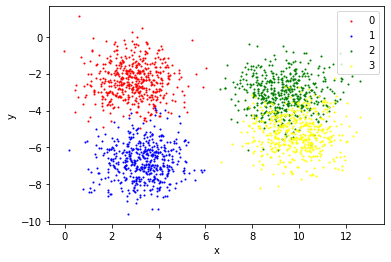

x         y  label
0   9.666005 -3.959415      3
1  10.278162 -3.392068      3
2   4.383861 -1.981555      0
3   3.182117 -3.001195      0
4   3.205353 -4.272643      0

In [78]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=2000, centers=4, n_features=2, random_state=30)
# scatter plot, dots colored by class value
synthetic = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'yellow'}
fig, ax = plt.subplots()
grouped = synthetic.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key], s=1.1)
plt.show()

synthetic.head()

In [87]:
synthetic['clusters'] = 0
synthetic['new_clusters'] = -1

a = np.random.choice([1.0, 0.0], size=len(synthetic), p=[0.7, 0.3])
synthetic["true_class"] = np.random.choice(a, size=len(synthetic))

b = np.random.choice([1.0, 0.0], size=len(synthetic), p=[0.6, 0.4])
synthetic['predicted_class'] = np.random.choice(b, size=len(synthetic))
synthetic['errors'] = abs(synthetic['predicted_class'] - synthetic['true_class'])
synthetic.head()

x         y  label  clusters  new_clusters  true_class  \
0   9.666005 -3.959415      3         0            -1         1.0   
1  10.278162 -3.392068      3         0            -1         1.0   
2   4.383861 -1.981555      0         0            -1         1.0   
3   3.182117 -3.001195      0         0            -1         1.0   
4   3.205353 -4.272643      0         0            -1         0.0   

   predicted_class  errors  
0              1.0     0.0  
1              0.0     1.0  
2              1.0     0.0  
3              0.0     1.0  
4              0.0     0.0

In [80]:
import os
path = r'..\\Preprocessed_datasets\\'
synthetic.to_csv(os.path.join(path, r'synthetic3.csv'))

<AxesSubplot:xlabel='x', ylabel='y'>

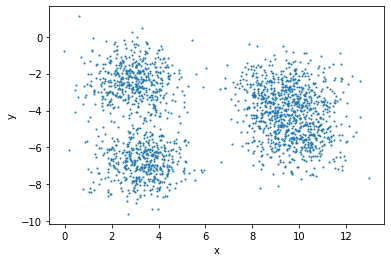

In [81]:
synthetic.plot.scatter("x", "y", s=1.1)

<AxesSubplot:xlabel='x', ylabel='y'>

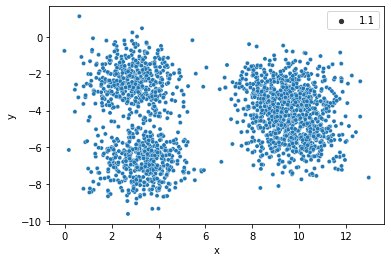

In [90]:
model = DBSCAN(eps=3, min_samples=100).fit_predict(synthetic)
sns.scatterplot(data=synthetic, x='x', y="y", size=1.1)
# plt.show()

<AxesSubplot:xlabel='x', ylabel='y'>

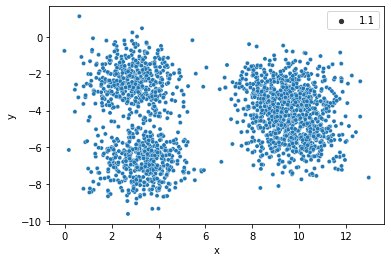

In [93]:
model2 = KMeans(n_clusters=2).fit_predict(synthetic)
sns.scatterplot(data=synthetic, x='x', y="y", size=1.1)

In [97]:
def dbscan(X, eps, min_samples):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired', s=1.1)
    plt.title("DBSCAN")

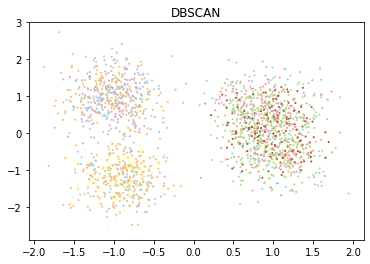

In [101]:
dbscan(synthetic, 1, 100)

In [94]:
def kmeans(X, n_clusters):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    y_pred = km.predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired', s=0.9)
    plt.title("K-means")

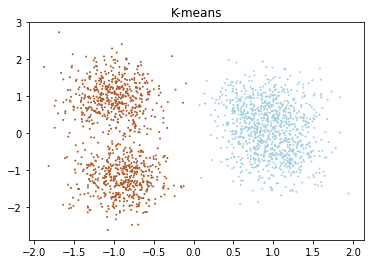

In [95]:
kmeans(synthetic, 2)

## Dimensionality Reduction


In [82]:
reduced_data = initialize_dataset(raw_data)
new2= initialize_dataset(raw_data, with_errors=False)


In [88]:
reduced_data = initialize_dataset(raw_data)

#pca features
to_reduce = reduced_data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1).columns
pca_features = PCA(n_components=2).fit_transform(reduced_data[to_reduce])

# other features (errors, true predictions)
non_reduced = pd.DataFrame()
non_reduced = reduced_data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]

# merging pca'd features with other features
reduced = pd.DataFrame(pca_features)
reduced = reduced.merge(non_reduced, left_index = True, right_index = True)

# final dataset to work with 
reduced.head()

0         1  scaled_errors  predicted_class  true_class  errors  \
0 -1.468126  0.624496            0.0                0         0.0     0.0   
2 -0.078468  2.895461            0.0                0         0.0     0.0   
3 -1.625901  0.254482            0.0                0         0.0     0.0   
5 -1.238491 -0.963425            0.3                1         0.0     1.0   
6 -0.467751 -1.264560            0.0                0         0.0     0.0   

   clusters  new_clusters  
0         0            -1  
2         0            -1  
3         0            -1  
5         0            -1  
6         0            -1

In [78]:
import os
path = r'..\\Clustered_datasets\\'
# reduced.to_csv(os.path.join(path, r'german_credit_pca.csv'))

In [ ]:
#pca features + unscaled errors
dataset = initialize_dataset(raw_data)

# features to be fed to pca
only_features = dataset.iloc[: , :24]

# Applying dimension reduction to the features
dimension_reduction = PCA(n_components=2).fit_transform(only_features)

# Putting the features in a dataframe
pca_features = pd.DataFrame(dimension_reduction)
pca_features.head()

In [ ]:
# exporting the biased cluster dataframe for further analysis
import os
path = r'..\\Clustered_datasets\\'
# reduced.to_csv(os.path.join(path, r'pca_german_credit.csv'))